In [1]:
# necessary packages
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np

# data reader
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)


C:\ProgramData\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### 神经网络

In [2]:
from torch import nn

# network definition
from MyNet import NeuralNetwork

In [3]:
# training module
def train(model, train_set, optimizer, log_interval, epoch_id, device, loss_list):
    print('\nTraining...')
    # start training
    model.train()
    for batch_id, (data, target) in enumerate(train_set):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        loss_list.append(loss.detach().cpu().item())

        if batch_id % log_interval == 0:
            print('Epoch: {}\tData: {}/{} ({:.0f}%)\tLoss: {:.10f}'.format(epoch_id, batch_id * len(data), len(train_set.dataset), 100. * batch_id / len(train_set), loss.item()))

In [4]:
# testing module
def test(model, test_set, device, loss_list, acc_list):
    print('\nTesting...')
    model.eval()
    avg_loss = 0
    correct_cnt = 0
    with torch.no_grad():
        for data, target in test_set:
            data, target = data.to(device), target.to(device)
            output = model(data)
            avg_loss += F.nll_loss(output, target).item() * len(data)
            pred = output.argmax(dim=1)
            correct_cnt += pred.eq(target).sum().item()
    avg_loss /= len(test_set.dataset)
    loss_list.append(avg_loss)
    accuracy = correct_cnt / len(test_set.dataset)
    acc_list.append(accuracy)

    print('Average Loss: {:.10f}\tAccuracy: {}/{}({:.0f}%)'.format(avg_loss, correct_cnt, len(test_set.dataset), 100. * accuracy))

In [5]:
# parameter settings
print('Learning initializing...')
CUDA_on = True
epochs = 10
learning_rate = 0.1
gamma = 0.7
log_interval = 10
batch_size = 100
test_batch_size = 1000


Learning initializing...


In [6]:
# instantiation
# device configurations
cuda = CUDA_on and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
if cuda:
    cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
else:
    cuda_kwargs = {}

# data loaders
train_set = torch.utils.data.DataLoader(training_data, batch_size=batch_size, **cuda_kwargs)
test_set  = torch.utils.data.DataLoader(test_data, batch_size=test_batch_size, **cuda_kwargs)

### 模型训练


In [7]:
model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = StepLR(optimizer, step_size=1, gamma=gamma)


In [8]:
# the real work
train_losses = []
test_losses = []
test_accuracies = []

for epoch_id in range(1, epochs + 1):
    train(model, train_set, optimizer, log_interval, epoch_id, device, train_losses)
    test(model, test_set, device, test_losses, test_accuracies)
    lr_scheduler.step()


Training...


C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1	Data: 0/60000 (0%)	Loss: 2.3179681301
Epoch: 1	Data: 1000/60000 (2%)	Loss: 2.1791548729
Epoch: 1	Data: 2000/60000 (3%)	Loss: 2.0558521748
Epoch: 1	Data: 3000/60000 (5%)	Loss: 0.8716437817
Epoch: 1	Data: 4000/60000 (7%)	Loss: 0.8023472428
Epoch: 1	Data: 5000/60000 (8%)	Loss: 1.3437623978
Epoch: 1	Data: 6000/60000 (10%)	Loss: 0.5858399272
Epoch: 1	Data: 7000/60000 (12%)	Loss: 0.3350922763
Epoch: 1	Data: 8000/60000 (13%)	Loss: 0.3531276584
Epoch: 1	Data: 9000/60000 (15%)	Loss: 0.7082307935
Epoch: 1	Data: 10000/60000 (17%)	Loss: 0.2508182228
Epoch: 1	Data: 11000/60000 (18%)	Loss: 0.3956637084
Epoch: 1	Data: 12000/60000 (20%)	Loss: 0.4783962369
Epoch: 1	Data: 13000/60000 (22%)	Loss: 0.3303456903
Epoch: 1	Data: 14000/60000 (23%)	Loss: 0.2366188616
Epoch: 1	Data: 15000/60000 (25%)	Loss: 0.3068576753
Epoch: 1	Data: 16000/60000 (27%)	Loss: 0.3914323747
Epoch: 1	Data: 17000/60000 (28%)	Loss: 0.3470457792
Epoch: 1	Data: 18000/60000 (30%)	Loss: 0.2526864707
Epoch: 1	Data: 19000/60000 (32%

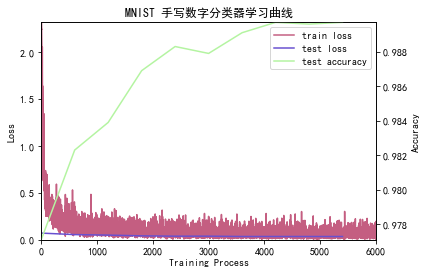

In [9]:
# visualization
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

fig, ax_loss = plt.subplots(figsize=(6,4))

length = len(train_losses)
x_train = range(length)
x_test = x_train[::length // len(test_losses)]
ax_acc = ax_loss.twinx()

# three lines
lns = []

lns += ax_loss.plot(x_train, train_losses, c='#c45e81', label='train loss')
lns += ax_loss.plot(x_test, test_losses, c='#6850d0', label='test loss')
lns += ax_acc.plot(x_test, test_accuracies, c='#b4f4a1', label='test accuracy')

ax_loss.set_ylim(0., max(max(train_losses), max(test_losses)))
ax_acc.set_ylim(min(test_accuracies), max(test_accuracies))
plt.xlim(0, length)
ax_loss.set_xlabel('Training Process')
ax_loss.set_ylabel('Loss')
ax_acc.set_ylabel('Accuracy')
plt.title('MNIST 手写数字分类器学习曲线')

# labels
labs = [l.get_label() for l in lns]
ax_loss.legend(lns, labs, loc=0)

plt.show()

### 模型保存与读取

In [10]:
# save model
torch.save(model, 'model.pth')

In [11]:
# load the model

model = torch.load('model.pth')
model.eval()

NeuralNetwork(
  (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

图片标签：4	预测结果：4
输入的图片：


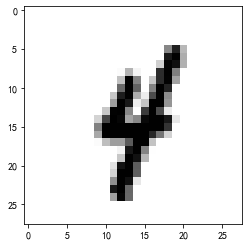

In [12]:
# randomly pick a picture and test the model
random_picker  = torch.utils.data.DataLoader(test_data, batch_size=1, **cuda_kwargs)
for pic, label in random_picker:
    pic = pic.to(device)
    label = label.item()
    break

with torch.no_grad():
    pred = model(pic).argmax(dim=1).item()

# show the picture
print('图片标签：{}\t预测结果：{}'.format(label, pred))
print('输入的图片：')
pic = pic.cpu().view(28, 28)
plt.imshow(1-pic, cmap=plt.cm.gray)

